We want to compare the performance of a cold resistor to that of our mode-cooling setup when it comes to attenuating noise in a signal.  It might be helpful to come up with some setup where we can look at the performance of each.  Suppose that we have an antenna for measuring some signal $S$ that is connected to some device.  In case A, we connect the antenna to the device with a simple circuit with a resistor $R=50\Omega$ behaving as though its at temperature $T'$ that is lower than the environment temperature $T$.  In case B, the antenna is connected to the cavity containing the NV ensemble.  The cavity has an input port, an output port, and an internal loss rate (coupling rates $\kappa$, $\gamma$, and $\Gamma$ respectively).  Each port is at the same temperature, so the commutation relations of the input modes each equal $n_T$.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [12]:
def resistor_noise(R, T, dw):
    """
    function for calculating the Johnson-Nyquist noise of a resistor (effectively the rms voltage)
    :param R:  the resistance of the resistor
    :param T:  the temperature of the resistor
    :param dW: the bandwidth of interest
    """
    k_B = 1.38e-23 
    return np.sqrt(4 * k_B * T * R * dw)

In [83]:
def output_noise(ω, κ, γ, Γ, r, g, nT, nc):
    """
    function for calculating the number noise photons in the output port of the cavity-NV ensemble setup
    :param ω:         the frequency range over which the integration is performed
    :param κ:         the coupling rate of the input port
    ;param γ:         the internal loss rate of the cavity
    :param Γ:         the coupling rate of the output port
    :param r:         the inhomogenous broadening of the spins
    :param g:         the collective coupling strength of the NV ensemble to the cavity
    :param nT:        the number of thermal photons at temperature T
    :param nc:        the number of effective photons from the spins
    :return:          the number of noise photons in the output port
    """
    # Define the numerator in parts
    num_a = (r ** 2 / 4 + ω ** 2) * (κ + γ) * Γ * nT + Γ * r * g ** 2 * nc
    num_b = np.abs(((Γ - κ - γ) / 2 + 1j * ω) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = num_a + num_b

    # Define the denominator
    den = np.abs(((κ + γ + Γ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return integrate.simpson(1 / (2 * np.pi) * num / den, x=ω, axis=0)

In [84]:
def output_signal(ω, κ, γ, Γ, r, g, S):
    """
    function for calculating the number of signal photons in the output port of the cavity-NV ensemble setup
    :param ω:         the frequency range over which the integration is performed
    :param κ:         the coupling rate of the input port
    ;param γ:         the internal loss rate of the cavity
    :param Γ:         the coupling rate of the output port
    :param r:         the inhomogenous broadening of the spins
    :param g:         the collective coupling strength of the NV ensemble to the cavity
    :param S:         the power spectral density of the input signal
    :return:          the number of signal photons in the output port
    """
    # Define the numerator
    num = (r ** 2 / 4 + ω ** 2) * Γ * κ

    # Define the denominator
    den = np.abs(((κ + γ + Γ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return integrate.simpson(1 / (2 * np.pi) * num / den * S, x=ω, axis=0)

## Results

First, we'll calculate ratio of the change in the SNR to the expected attenuation of noise for the resistor as its effective temperature changes.  I guess we'll start at room temperature for now.

In [9]:
# Define parameters
R = 50    # resistance of our resistor in Ω
T = 300   # environment temperature in K
Δf = 10e3 # bandwidth of our measurement in Hz

In [10]:
# Set the range of the effective temperature
T_eff = np.linspace(100, 200, 1000)

In [19]:
# Calculate the attenuation factor
α = resistor_noise(R, T_eff, Δf) / resistor_noise(R, T, Δf)

Text(0, 0.5, '$\\Delta\\mathrm{SNR}_A$')

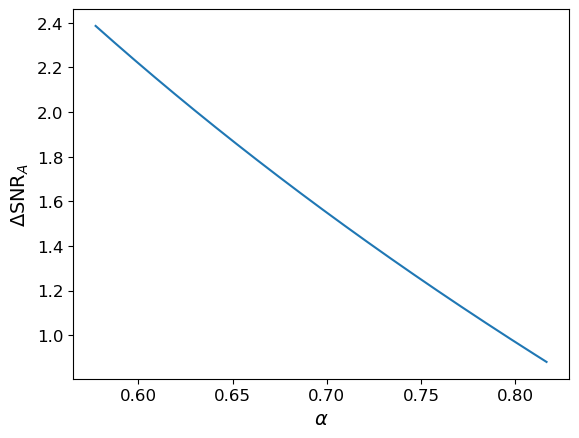

In [18]:
# The signal portion actually ends up cancelling when you look at the change in SNR
ΔSNR_A = 10 * np.log10(resistor_noise(R, T, Δf) / resistor_noise(R, T_eff, Δf))

# Plot
plt.plot(α, ΔSNR_A)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\Delta\\mathrm{SNR}_A$")

Now we can look at the results of the cavity-NV ensemble setup.  Note that we have to do numerical integration to get results, so we'll have to make an assumption about the power spectral density of the input signal.  I'm not sure how much this will matter, but for now we'll go ahead and assume that its a constant with magnitude $10n_T$.

In [77]:
# Define parameters - we'll use smallish numbers to make things easier to process.  And we'll assume good cooling, so g >> κ, γ, Γ, r = 2g
ωc = 2 * np.pi * 2.87e9
Q = 1e6
γ = ωc / Q
κ = 100*γ
Γ = κ
g = 1e6
r = 2 * g

nT = temp_from_photons(ωc, T)
P = 0.8
nc = 0.5 * (1 - P) / P

In [78]:
# Define our integration bounds
ω = 2 * np.pi * np.linspace(-Δf / 2, Δf / 2, 1000)

In [85]:
# Calculate values if the cavity weren't there for later comparison
signal_base = Δf * 10 * nT
noise_base = Δf * nT
SNR_B_base = 10*np.log10(signal_base / noise_base)

In [86]:
# Now do the integrations and calculate the SNR
signal = output_signal(ω, κ, γ, Γ, r, g, 10*nT)
noise = output_noise(ω, κ, γ, Γ, r, g, nT, nc)
SNR_B = 10*np.log10(signal / noise)

In [87]:
# Calculate the difference in SNR
ΔSNR_B = SNR_B - SNR_B_base

# Calculate the attenuation factor
β = noise / noise_base

In [88]:
# Print
β, ΔSNR_B, ΔSNR_B / β

(0.5454133515963034, -1.226210421404545, -2.248222229646011)

In [90]:
# Let g vary
g = np.logspace(4, 8)
gm, ωm = np.meshgrid(g, ω)

signal = output_signal(ωm, κ, γ, Γ, 2*gm, gm, 10*nT)
noise = output_noise(ωm, κ, γ, Γ, 2*gm, gm, nT, nc)
SNR_B = 10*np.log10(signal / noise)
ΔSNR_B =  SNR_B - SNR_B_base
β = noise / noise_base

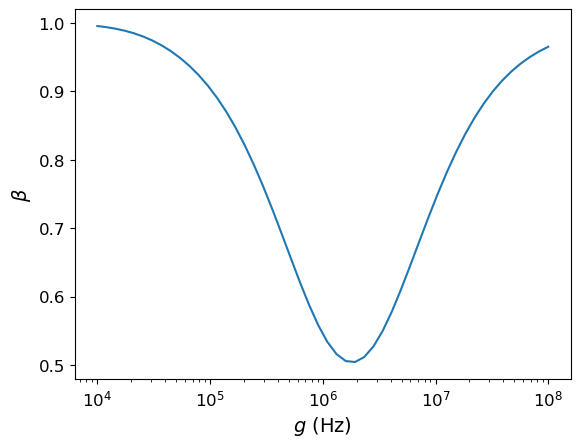

In [94]:
plt.plot(g, β)
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\beta$")
plt.xscale('log')

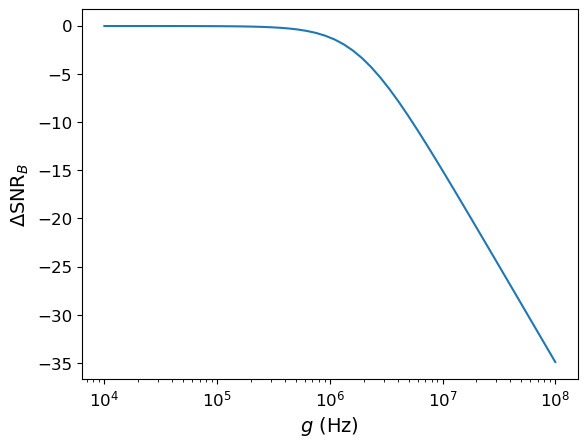

In [95]:
plt.plot(g, ΔSNR_B)
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\Delta\\mathrm{SNR}_B$")
plt.xscale('log')